26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


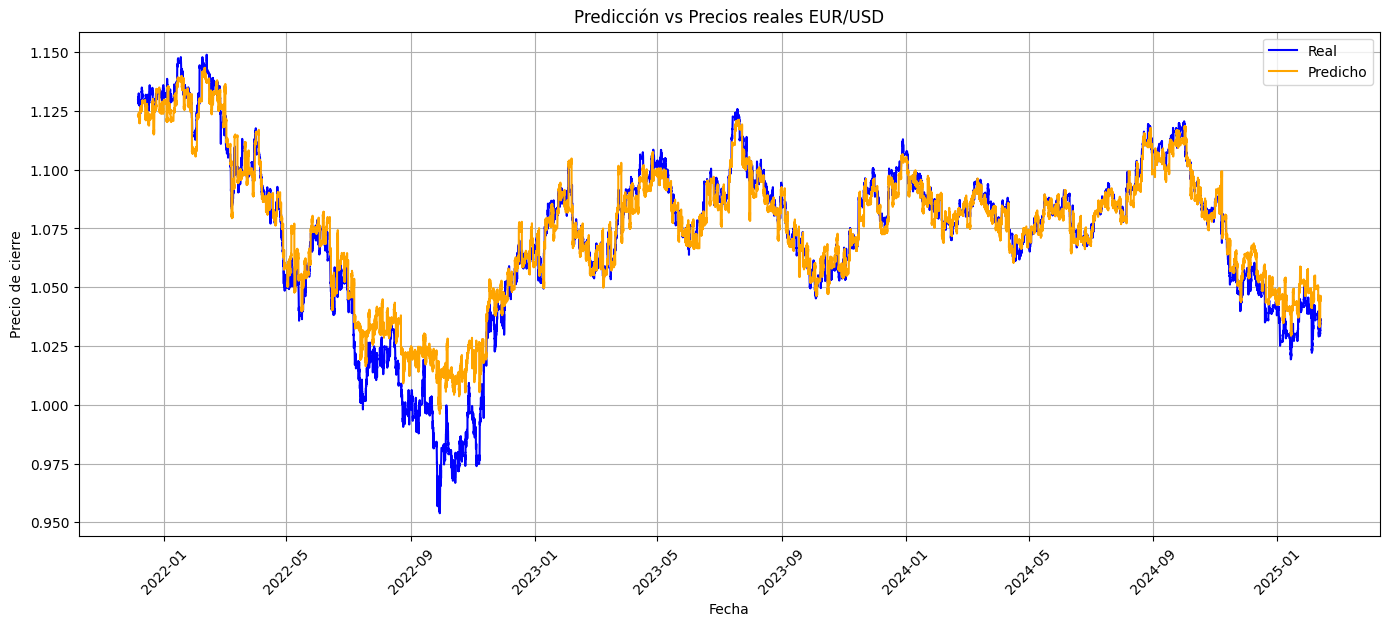

In [33]:
#### EVALUATING TESTING #######

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import joblib

# File paths
model_path = './models/model_16.keras'
scaler_path = '../data/scalers/Close_scaler.pkl'
test_data_path = '../data/test_scaled.csv'  # already scaled
look_back = 60
forecast = 24
 # or however many you used

# Load model
model = load_model(model_path)

# Load scaler (fitted on 'Close' column)
scaler = joblib.load(scaler_path)

# Load test data
df_test = pd.read_csv(test_data_path, index_col='Date')

n_features = df_test.columns.size

# Create input/output sets
def create_dataset(df, look_back, forecast):
    X, y = [], []
    for i in range(0, len(df) - look_back - forecast + 1, forecast):
        X.append(df.iloc[i:i+look_back].values)
        y.append(df.iloc[i+look_back:i+look_back+forecast]['Close'].values)
    return np.array(X), np.array(y)

def inverse_transform_close_column(scaler, y_scaled, num_features):
    y_scaled = y_scaled.flatten().reshape(-1, 1)

    # Create dummy with same number of features
    dummy = np.zeros((y_scaled.shape[0], num_features))
    dummy[:, 0] = y_scaled[:, 0]  # Inject into the first column (Close)

    # Inverse transform and return only the Close column
    unscaled = scaler.inverse_transform(dummy)
    return unscaled[:, 0]


X_test, y_true_scaled = create_dataset(df_test, look_back, forecast)

# Reshape for model input
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)

# Predict
y_pred_scaled = model.predict(X_test)

# Unscale (only Close target)
y_pred = inverse_transform_close_column(scaler, y_pred_scaled, num_features=n_features)

y_true = inverse_transform_close_column(scaler, y_true_scaled, num_features=n_features)

# Get the matching dates
start_idx = look_back + forecast - 1
date_range = test_df.index[start_idx:start_idx + min(len(y_true), len(df_test) - start_idx)]
y_true = y_true[:len(date_range)]
y_pred = y_pred[:len(date_range)]

# Plot
plt.figure(figsize=(14, 6))
plt.plot(date_range, y_true, label="Real", color="blue")
plt.plot(date_range, y_pred, label="Predicho", color="orange")
plt.title("Predicción vs Precios reales EUR/USD")
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [34]:
def naive_forecast(test_dataset, look_back, forecast):
    """
    Implements a naive forecasting model (persistence model).

    Args:
        test_dataset (pd.DataFrame): The full test dataset including 'Close' column.
        look_back (int): Number of time steps used as input.
        forecast (int): Number of future time steps to predict.

    Returns:
        predictions (list): List of arrays, each containing a forecast of 'forecast' length.
        actuals (list): Corresponding ground truth sequences.
    """
    predictions = []
    actuals = []

    for i in range(0, len(test_dataset) - look_back - forecast + 1, forecast):
        input_seq = test_dataset.iloc[i : i + look_back]
        last_close = input_seq['Close'].iloc[-1]

        # Predict the same value for each step ahead
        pred = np.full(shape=forecast, fill_value=last_close)
        predictions.append(pred)

        # Get actual values for this forecast window
        actual = test_dataset.iloc[i + look_back : i + look_back + forecast]['Close'].values
        actuals.append(actual)

    return predictions, actuals


In [35]:
naive_preds, naive_actuals = naive_forecast(df_test, look_back=60, forecast=24)

from sklearn.metrics import mean_squared_error

model_rmse = np.sqrt(mean_squared_error(y_true_scaled, y_pred_scaled))
naive_rmse = np.sqrt(mean_squared_error(np.concatenate(naive_actuals), np.concatenate(naive_preds)))
print(f"Model RMSE: {model_rmse:.6f}")
print(f"Naive Forecast RMSE: {naive_rmse:.6f}")


Model RMSE: 0.087934
Naive Forecast RMSE: 0.033041


In [36]:
def directional_accuracy(true_seq, pred_seq):
    correct = 0
    total = 0

    for true, pred in zip(true_seq, pred_seq):
        # Compare direction between each time step within the same sample
        true_diff = np.diff(true)
        pred_diff = np.diff(pred)
        correct += np.sum(np.sign(true_diff) == np.sign(pred_diff))
        total += len(true_diff)

    return correct / total if total > 0 else 0

In [37]:
model_da= directional_accuracy(y_true_scaled, y_pred_scaled)
naive_da =directional_accuracy(naive_actuals, naive_preds)
print(f"Model DA: {model_da:.6f}")
print(f"Naive Forecast DA: {naive_da:.6f}")

Model DA: 0.505500
Naive Forecast DA: 0.007543


In [38]:
print(f"Model composite score: {model_rmse-0.1*model_da:.6f}")
print(f"Naive Forecast composite score: {naive_rmse-0.1*naive_da:.6f}")

Model composite score: 0.037384
Naive Forecast composite score: 0.032286


In [39]:
start_2023 = df_test.index.get_loc(df_test[pd.to_datetime(df_test.index).year == 2023].index[0])

model_rmse = np.sqrt(mean_squared_error(y_true[start_2023:], y_pred[start_2023:]))
naive_rmse = np.sqrt(mean_squared_error(np.concatenate(naive_actuals)[start_2023:], np.concatenate(naive_preds)[start_2023:]))
print(f"Model RMSE post 2023: {model_rmse:.6f}")
print(f"Naive Forecast RMSE post 2023: {naive_rmse:.6f}")

Model RMSE post 2023: 0.005621
Naive Forecast RMSE post 2023: 0.028107


In [40]:
model_rmse = np.sqrt(mean_squared_error(y_true[:start_2023], y_pred[:start_2023]))
naive_rmse = np.sqrt(mean_squared_error(np.concatenate(naive_actuals)[:start_2023], np.concatenate(naive_preds)[:start_2023]))
print(f"Model RMSE pre 2023: {model_rmse:.6f}")
print(f"Naive Forecast RMSE pre 2023: {naive_rmse:.6f}")

Model RMSE pre 2023: 0.015561
Naive Forecast RMSE pre 2023: 0.040912


In [41]:
import numpy as np
from sklearn.metrics import mean_squared_error


def permutation_feature_importance(model, X, y_true, metric=mean_squared_error):
    """
    Estimate feature importance by measuring performance drop when shuffling each feature.

    Args:
        model: Trained Keras model.
        X (ndarray): Input of shape (samples, timesteps, features).
        y_true (ndarray): Flattened true target values.
        metric: A function to measure error (default: mean_squared_error).

    Returns:
        importance_scores (list of float): Performance drop per feature.
    """
    forecast = model.output_shape[-1]
    min_len = min(X.shape[0] * forecast, y_true.size)

    baseline_preds = model.predict(X, verbose=0).flatten()[:min_len]
    y_true_trimmed = y_true[:min_len]
    baseline_score = metric(y_true_trimmed, baseline_preds)

    n_features = X.shape[2]
    importance_scores = []

    for f in range(n_features):
        X_permuted = np.copy(X)

        # Shuffle the feature across all samples and timesteps
        for t in range(X.shape[1]):
            np.random.shuffle(X_permuted[:, t, f])

        permuted_preds = model.predict(X_permuted, verbose=0).flatten()[:min_len]
        permuted_score = metric(y_true_trimmed, permuted_preds)
        importance = permuted_score - baseline_score
        importance_scores.append(importance)

        print(f"Feature {f}: Importance = {importance:.6f}")

    return importance_scores


Feature 0: Importance = 0.058549
Feature 1: Importance = 0.028266
Feature 2: Importance = 0.081678
Feature 3: Importance = 0.005000
Feature 4: Importance = 0.048630
Feature 5: Importance = 0.057950
Feature 6: Importance = 0.077002
Feature 7: Importance = 0.090731
Feature 8: Importance = 0.006448
Feature 9: Importance = 0.022264
Feature 10: Importance = 0.026795
Feature 11: Importance = 0.222725


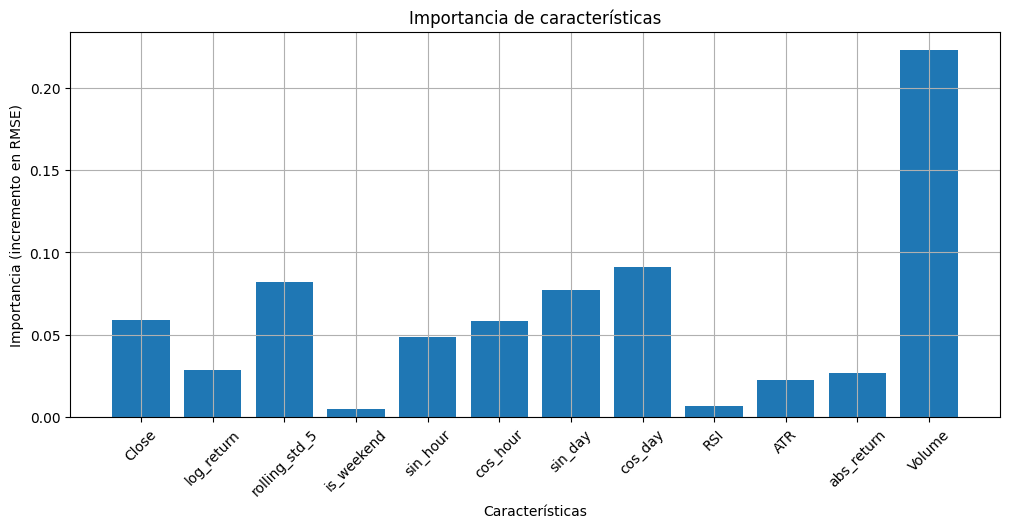

In [42]:
import matplotlib.pyplot as plt

# Run permutation importance
importances = permutation_feature_importance(model, X_test, y_true)

# Plot
plt.figure(figsize=(12, 5))
plt.bar(range(len(importances)), importances)
plt.title("Importancia de características")
plt.xticks(ticks=range(len(importances)), labels=selected_features, rotation=45)
plt.xlabel("Características")
plt.ylabel("Importancia (incremento en RMSE)")
plt.grid(True)
plt.show()


In [43]:
def recommend_by_threshold(predicted_price, current_price, threshold=0.0005):
    delta = (predicted_price - current_price) / current_price

    if delta > threshold:
        return 'long'
    elif delta < -threshold:
        return 'short'
    else:
        return 'hold'


In [59]:
import numpy as np
import pandas as pd

def backtest_strategy_with_arrays(y_true, y_pred, test_df, threshold=0.0005):
    """
    Backtests the trading strategy based on predicted vs. real values.

    Args:
        y_true (np.array): Array of true 'Close' values.
        y_pred (np.array): Array of predicted 'Close' values.
        test_df (pd.DataFrame): Test dataset with 'Close' for dates.
        threshold (float): Threshold for price difference to trigger trades.

    Returns:
        pd.DataFrame: Backtesting results with trades, returns, and equity curve.
    """
    results = []
    initial_capital = 1000

    # Assuming y_true and y_pred are aligned with test_df
    for i in range(len(y_true)):
        current_price = y_true[i]
        future_price = y_pred[i]  # Predicted price

        recommendation = recommend_by_threshold(future_price, current_price, threshold)

        # Simulate trade (using next day's price for entry/exit)
        if recommendation == 'long':
            trade_price = y_true[i]
            try:
                exit_price = y_true[i + 1]  # Next day's true price
            except IndexError:
                break  # Handle end of data
            trade_return = (exit_price - trade_price) / trade_price
            initial_capital *= (1 + trade_return)
            results.append([test_df.index[i], 'long', trade_price, future_price, exit_price, trade_return, initial_capital])

        elif recommendation == 'short':
            trade_price = y_true[i]
            try:
                exit_price = y_true[i + 1]
            except IndexError:
                break
            trade_return = (trade_price - exit_price) / trade_price
            initial_capital *= (1 + trade_return)
            results.append([test_df.index[i], 'short', trade_price, future_price, exit_price, trade_return, initial_capital])

    results_df = pd.DataFrame(results, columns=['Date', 'Action', 'Entry Price', 'Predicted Exit Price', 'Real Exit Price', 'Return', 'Equity'])
    results_df.set_index('Date', inplace=True)

    return results_df

In [60]:
import pandas as pd

def calculate_annualized_return(backtest_results):
    """
    Calculates the annualized return of a trading strategy.

    Args:
        backtest_results (pd.DataFrame): DataFrame with 'Equity' column from backtesting.

    Returns:
        float: Annualized return.
    """
    # Get the initial and final equity
    initial_equity = backtest_results['Equity'].iloc[0]
    final_equity = backtest_results['Equity'].iloc[-1]

    # Calculate the total return
    total_return = (final_equity - initial_equity) / initial_equity

    # Calculate the number of years
    start_date = backtest_results.index[0]
    end_date = backtest_results.index[-1]
    num_years = (end_date - start_date).days / 365.25  # Account for leap years

    # Calculate the annualized return
    annualized_return = (1 + total_return) ** (1 / num_years) - 1

    return annualized_return

In [63]:
backtest_results = backtest_strategy_with_arrays(y_true, y_pred, test_df, threshold=0.0001)
annualized_return = calculate_annualized_return(backtest_results)
total_return = (backtest_results['Equity'].iloc[-1] - backtest_results['Equity'].iloc[0]) / backtest_results['Equity'].iloc[0]

worst_return = backtest_results['Return'].min()
best_return = backtest_results['Return'].max()

print(f"Retorno anual: {annualized_return:.2%}")
print(f"Peor retorno: {worst_return:.2%}")
print(f"Mejor retorno: {best_return:.2%}")
print(f"Retorno total: {total_return:.2%}")
print(f"Numero de transacciones: {len(backtest_results)}")

Retorno anual: 4.70%
Peor retorno: -1.37%
Mejor retorno: 1.74%
Retorno total: 15.75%
Numero de transacciones: 19610


In [48]:
backtest_results

,Action,Entry Price,Exit Price,Return,Equity
Date,,,,,
2021-11-30 14:00:00,short,1.12953,1.12940,0.000115,1000.115092
2021-11-30 15:00:00,short,1.12940,1.12975,-0.000310,999.805157
2021-11-30 16:00:00,short,1.12975,1.12991,-0.000142,999.663561
2021-11-30 17:00:00,short,1.12991,1.12827,0.001451,1001.114515
2021-11-30 18:00:00,short,1.12827,1.12922,-0.000842,1000.271580
...,...,...,...,...,...
2025-02-07 06:00:00,long,1.03453,1.03578,0.001208,1162.807023
2025-02-07 07:00:00,long,1.03578,1.03628,0.000483,1163.368342
2025-02-07 08:00:00,long,1.03628,1.03609,-0.000183,1163.155041


from matplotlib import pyplot as plt
_df_0['Entry Price'].plot(kind='hist', bins=20, title='Entry Price')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Exit Price'].plot(kind='hist', bins=20, title='Exit Price')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Return'].plot(kind='hist', bins=20, title='Return')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Equity'].plot(kind='hist', bins=20, title='Equity')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Action').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Entry Price', y='Exit Price', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Exit Price', y='Return', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Return', y='Equity', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Entry Price']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('Date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Action')):
  _plot_series(series, series_name, i)
  fig.legend(title='Action', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Entry Price')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Exit Price']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('Date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Action')):
  _plot_series(series, series_name, i)
  fig.legend(title='Action', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Exit Price')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Return']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('Date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Action')):
  _plot_series(series, series_name, i)
  fig.legend(title='Action', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Return')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Equity']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('Date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Action')):
  _plot_series(series, series_name, i)
  fig.legend(title='Action', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Equity')

from matplotlib import pyplot as plt
_df_12['Entry Price'].plot(kind='line', figsize=(8, 4), title='Entry Price')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['Exit Price'].plot(kind='line', figsize=(8, 4), title='Exit Price')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Return'].plot(kind='line', figsize=(8, 4), title='Return')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Equity'].plot(kind='line', figsize=(8, 4), title='Equity')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_16['Action'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_16, x='Entry Price', y='Action', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['Action'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='Exit Price', y='Action', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['Action'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='Return', y='Action', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['Action'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='Equity', y='Action', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)